In [8]:
## Evalutate the effect of Zero phase in network inversion
## Test data: SenDT128

import os
import numpy as np
from matplotlib import ticker, pyplot as plt, gridspec
from pysar.objects import timeseries, ifgramStack, geometry, sensor
from pysar.utils import plot as pp, network as pnet, ptime
from pysar.simulation import simulation as sim
from pysar.simulation.plot import *
from pysar import ifgram_inversion as ifginv


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)

ref_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR'
ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
pts_yx = [290, 415]
sensorName = sensor.project_name2sensor(ref_dir)[0]

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase


In [9]:
ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)

with open('bl_list.txt', 'w') as f:
    print('writing >>> bl_list.txt')
    for d, pbase in zip(ptime.yymmdd(date_list), pbase_list):
        f.write('{}\t{}\n'.format(d, pbase))

## 1. Linear velocity to timeseries
TS_TXT_FILE = 'timeseries'
ts_sim = sim.velocity2timeseries(date_list, vel=0.03, display=False)
np.save(TS_TXT_FILE, np.hstack((np.array(date_list).reshape(-1,1), ts_sim.reshape(-1,1))))
print('save range change time series to file.')

display = False
if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.scatter(tbase_list, ts_sim*100.0, s=marker_size**2)
    ax.set_xlabel('Time (days)', fontsize=font_size)
    ax.set_ylabel('Displacement (cm)', fontsize=font_size)
    #ax.set_xlim([-200,2900])
    ax.tick_params(direction='in', labelsize=font_size)
    plt.savefig('SimTimeseriesLin'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    #plt.title('Displacement time series')
    #plt.show()
    
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase_list, pbase_list, '-ko', alpha=0.8, lw=1, ms=marker_size, mfc='orange')
    ax = pp.auto_adjust_yaxis(ax, pbase_list, font_size)
    ax.set_xlabel('Time (days)',fontsize=font_size)
    ax.set_ylabel('Perpendicular Baseline (m)',fontsize=font_size)
    #ax.set_xlim([-200,2900])
    ax.tick_params(direction='in', labelsize=font_size)
    plt.savefig('BaselineHistory'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    plt.show()

# Read coherence/date12_list from reference file
stack_obj = ifgramStack(os.path.join(ref_dir, 'INPUTS/ifgramStack.h5'))
stack_obj.open()
geom_obj = geometry(os.path.join(ref_dir, 'INPUTS/geometryRadar.h5'))
inc_angle = np.nanmean(geom_obj.read(datasetName='incidenceAngle'))

date12_list = stack_obj.date12List                # use pairs from data file
date12_list = pnet.select_pairs_all(date_list)    # use all pairs for demonstration
date12_list = ptime.yyyymmdd_date12(date12_list)

box = (pts_yx[1], pts_yx[0], pts_yx[1]+1, pts_yx[0]+1)
coh = stack_obj.read(datasetName='coherence', box=box)

coh = pnet.simulate_coherence(date12_list,
                              baseline_file='bl_list.txt',
                              sensor_name=sensorName,
                              inc_angle=inc_angle,
                              decor_time=200.0,
                              coh_resid=0.2)

# Simulate coherence/date12_list

if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax = pp.plot_coherence_matrix(ax, date12_list, coh.tolist())
    plt.show()

print('simulate unwrapped phase')
wvl = sensor.wavelength('Sen')
range2phase = -4.0 * np.pi / wvl
ifgram_sim = sim.timeseries2ifgram(ts_sim, date_list, date12_list, wvl=wvl, display=display)

print('simulate decorrelation noise')
L = int(stack_obj.metadata['ALOOKS']) * int(stack_obj.metadata['RLOOKS'])
decor_noise_file = 'decor_noise.npy'
re_generate_noise = True
if re_generate_noise or not os.path.isfile(decor_noise_file):
    decor_sim = sim.simulate_decorrelation_noises(date12_list, coh, L=L, display=display)
    np.save(decor_noise_file, decor_sim)
else:
    decor_sim = np.load(decor_noise_file)

# ifgram with decor noise
ifgram_comb = ifgram_sim + decor_sim

min_coh = 0.4
if min_coh != 0.:
    ifgram_comb[coh<min_coh] = 0.

print('Done.')

open timeseries file: timeseries.h5
writing >>> bl_list.txt
save range change time series to file.
open ifgramStack file: ifgramStack.h5
reading incidenceAngle data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/geometryRadar.h5 ...
reading coherence data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/ifgramStack.h5 ...
simulate unwrapped phase
simulate decorrelation noise
Done.


In [11]:
## Invert network of ifgrams into time-series
print('Inverting timeseries ...')
A, B = stack_obj.get_design_matrix(date12_list=date12_list)
weight = ifginv.coherence2fisher_info_index(coh, L)
ts_inv = ifginv.network_inversion_wls(A, ifgram_comb, weight, skip_zero_phase=True)[0]
ts_inv = np.vstack((0, ts_inv)) / range2phase

ts_inv_noskip = ifginv.network_inversion_wls(A, ifgram_comb, weight, skip_zero_phase=False)[0]
ts_inv_noskip = np.vstack((0, ts_inv_noskip)) / range2phase

ts_inv_sbas_noskip = ifginv.network_inversion_sbas(B, ifgram_comb, tbase_diff, skip_zero_phase=False)[0]
ts_inv_sbas_noskip = np.vstack((0, ts_inv_sbas_noskip)) / range2phase
print('Done.')

Inverting timeseries ...
Done.


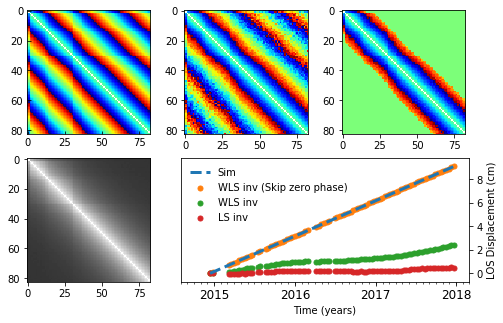

In [31]:
# plot ifgram simulation process
def plot_invert_timeseries(ax, data_list, label_list):
    ax.plot(dates, list(data_list[0]*100.0),
            '--', lw=3, label=label_list[0], color=pp.mplColors[0])
    for data, label, i in zip(data_list[1:],
                              label_list[1:],
                              range(1, len(data_list))):
        ax.scatter(dates, list(data*100.0),
                   s=marker_size**2, label=label, color=pp.mplColors[i])
    pp.auto_adjust_xaxis_date(ax, datevector, fontSize=12, every_year=1)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('LOS Displacement (cm)')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    #ax.set_title('Time series displacement - Inversed')
    ax.legend(frameon=False)

fig = plt.figure(figsize=[8, 5])
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)
ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1], sharex=ax11, sharey=ax11)
ax13 = plt.subplot(gs[0, 2], sharex=ax11, sharey=ax11)
ax21 = plt.subplot(gs[1, 0], sharex=ax11, sharey=ax11)
ax22 = plt.subplot(gs[1, 1:])

#fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, )
wrap = True
for ax, data in zip([ax11, ax12, ax13],
                    [ifgram_sim, ifgram_sim+decor_sim, ifgram_comb]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    data_mat -= np.round(data_mat/(2*np.pi)) * (2*np.pi)
    im = ax.imshow(data_mat, cmap='jet', vmin=-np.pi, vmax=np.pi)


data_mat = pnet.coherence_matrix(date12_list, coh)
ax21.imshow(data_mat, cmap='gray', vmin=0, vmax=1)
ax22 = plot_invert_timeseries(ax22, 
                              data_list=[ts_sim, ts_inv, ts_inv_noskip, ts_inv_sbas_noskip],
                              label_list=['Sim',
                                          'WLS inv (Skip zero phase)',
                                          'WLS inv',
                                          'LS inv'])

ax11.tick_params(direction='in')
#for ax in [ax11, ax12, ax13, ax21, ax22]:
#    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
#fig.subplots_adjust(right=0.93)
#cax = fig.add_axes([0.94, 0.3, 0.005, 0.4])
#cbar = plt.colorbar(im, cax=cax)
#cbar.locator = ticker.MaxNLocator(nbins=4)
#cbar.update_ticks()

#plt.savefig('ifgram_sim.png', bbox_inches='tight', dpi=fig_dpi)
plt.show()

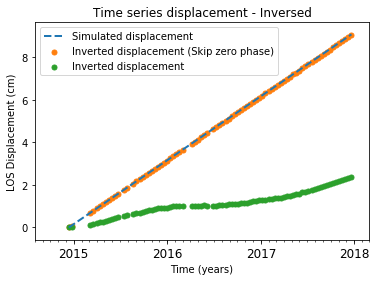

In [4]:

fig, ax = plt.subplots()

plt.savefig('NetworkInv_simulation.png', bbox_inches='tight', dpi=fig_dpi)
plt.show()